In [12]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [13]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.subsample import get_subsample
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from gmr import MVN
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from numpy import percentile
from scipy.stats import binned_statistic

In [14]:
geo = pd.read_csv('../data/daks_processed_with_rf.csv')
geo.head(10)
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Depositional environment', 'Gross','Netpay','Porosity','Permeability', 'Depth', 'Oil density', 'Oil recovery factor']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [4]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Depositional environment': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont',
 'Oil density': 'cont',
 'Oil recovery factor': 'cont'}

In [5]:
geo_signs = get_nodes_sign(geo)
geo_signs

{'Gross': 'pos',
 'Netpay': 'pos',
 'Porosity': 'pos',
 'Permeability': 'pos',
 'Depth': 'pos',
 'Oil density': 'pos',
 'Oil recovery factor': 'pos'}

In [6]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [7]:
geo_coded, label_coder = code_categories(geo, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo, 'equal_frequency', columns_for_disc)

In [8]:
bn_full = structure_learning(geo_discrete, 'HC', geo_types, 'K2')
bn_full

  0%|          | 21/1000000 [00:11<156:33:25,  1.77it/s]


{'V': ['Tectonic regime',
  'Period',
  'Lithology',
  'Structural setting',
  'Hydrocarbon type',
  'Depositional environment',
  'Gross',
  'Netpay',
  'Porosity',
  'Permeability',
  'Depth',
  'Oil density',
  'Oil recovery factor'],
 'E': [['Period', 'Structural setting'],
  ['Period', 'Porosity'],
  ['Period', 'Depth'],
  ['Period', 'Oil density'],
  ['Lithology', 'Depositional environment'],
  ['Lithology', 'Permeability'],
  ['Lithology', 'Period'],
  ['Lithology', 'Depth'],
  ['Lithology', 'Oil density'],
  ['Structural setting', 'Tectonic regime'],
  ['Structural setting', 'Netpay'],
  ['Structural setting', 'Oil density'],
  ['Structural setting', 'Depth'],
  ['Hydrocarbon type', 'Netpay'],
  ['Hydrocarbon type', 'Oil recovery factor'],
  ['Depositional environment', 'Netpay'],
  ['Netpay', 'Gross'],
  ['Porosity', 'Permeability'],
  ['Porosity', 'Depth'],
  ['Permeability', 'Oil recovery factor'],
  ['Permeability', 'Oil density']]}

In [9]:
params = parameter_learning(geo, geo_types, bn_full, 'mix')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [10]:
acc, rmse, real, pred = calculate_acc(all_bn, geo, ['Gross','Netpay','Porosity','Permeability', 'Depth', 'Oil recovery factor'], 'mix', normed=False)

In [29]:
acc

{}

In [11]:
rmse

{'Gross': 431.2,
 'Netpay': 79.13,
 'Porosity': 7.32,
 'Permeability': 748.91,
 'Depth': 964.07,
 'Oil recovery factor': 0.14}

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

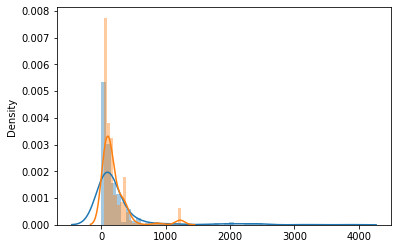

In [14]:
sns.distplot(real[0])
sns.distplot(pred[0])

In [18]:
mask = yhat != -1
geo[mask]

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Depositional environment,Gross,Netpay,Porosity,Permeability,Depth,Oil density,Oil recovery factor
0,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,OIL,SHELF-,76.2,30.5,21.0,60.0,1510.7,825.072886,0.26
1,GRAVITY,CRETACEOUS,LIMESTONE,PASSIVE MARGIN,OIL,SHELF-,29.0,4.6,12.0,20.0,2652.4,801.699717,0.34
2,EXTENSION,PALEOGENE,THINLY-BEDDED SANDSTONE,RIFT,OIL,SLOPE APRON,91.5,82.3,35.0,3500.0,1720.1,933.993399,0.36
3,STRIKE-SLIP,ORDOVICIAN,DOLOMITE,INTRACRATONIC,OIL,OPEN SHELF,182.9,122.0,4.0,10.0,1158.5,815.561960,0.48
4,COMPRESSION,CARBONIFEROUS,LIMESTONE,SUB-SALT,OIL,SHELF-,91.5,32.0,10.0,20.0,1829.3,876.160991,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,LACUSTRINE FAN-DELTA,50.0,18.9,23.2,121.0,1439.3,946.488294,0.13
339,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,SUBLACUSTRINE FAN,89.9,24.1,21.0,60.0,2310.7,881.619938,0.19
340,EXTENSION,MESOZOIC,VOLCANICS,RIFT,OIL,NOT APPLICABLE,150.0,59.1,12.7,3.6,3000.9,870.769231,0.05
341,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,OIL,SHORELINE,79.9,10.1,24.0,30.0,570.1,887.147335,0.24


In [42]:
def n_comp_sample (size: int, d: int):
    d1_05 = [0.225, 0.417]
    d1_08 = [0.136, 0.79]
    d1_099 = [0.015, 1.391]
    d2_08 = [0.07, 0.703]
    d3_08 = [0.042, 0.547]
    n = 1
    if (size <= 50) & (d == 1):
        n = size*d1_05[0] + d1_05[1]
    if (size > 50) & (size <= 100) & (d == 1):
        n = size*d1_08[0] + d1_08[1]
    if (size > 100) & (d == 1):
        n = size*d1_099[0] + d1_099[1]
    if d == 2:
        n = size*d2_08[0] + d2_08[1]
    if d == 3:
        n = size*d3_08[0] + d3_08[1]
    return n


In [39]:
n = n_component(geo, ['Netpay'])
n

4

In [43]:
n_comp_sample(geo.shape[0], 1)

6.536

In [115]:
n=4

In [116]:
means = []
cov = []
w = [1/n for o in range(n)]
for i in range(n):
    means.append([random.randint(0, 1000)])
    cov.append([[random.randint(100, 300)]])

In [117]:
means

[[110], [847], [12], [686]]

In [118]:
cov

[[[111]], [[175]], [[257]], [[103]]]

In [119]:
m = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)

In [120]:
sample = m.sample(1000000)

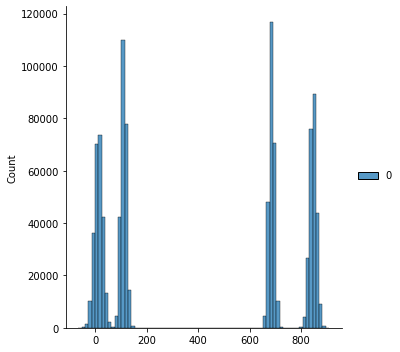

In [121]:
sns.displot(sample)

In [61]:
def LL_up (sample, n, means, cov, w):
    comp_dens = []
    for k in range (n):
        comp_dens.append(w[k]*MVN(mean=means[k], covariance=cov[k]).to_probability_density(sample))
    comp_dens = np.log(np.sum(comp_dens, axis=0))
    return np.mean(sample)*((np.sum(comp_dens)))

In [4]:
def LL_sample (sample, n, means, cov, w):
    comp_dens = []
    for k in range (n):
        comp_dens.append(w[k]*MVN(mean=means[k], covariance=cov[k]).to_probability_density(sample))
    comp_dens = np.log(np.sum(comp_dens, axis=0))
    return (np.sum(comp_dens))/len(sample)

In [76]:
LL_sample(sample, n, means, cov, w)

-4.6778808796811235

In [122]:
m1 = GaussianMixture(n_components=n).fit(sample)
round(m1.lower_bound_,3)

-5.312

In [57]:
def difference_ndarray(a, b):
    diff = []
    for element in a:
        if element not in b:
            diff.append(element)
    return(diff)

In [54]:
random_state = check_random_state(0)

In [127]:
n = 2
b = 0.99
mean_res = []
for k in range (10):
    print(k)
    means =[]
    cov = []
    w = [1/n for _ in range(n)]
    for i in range(n):
        means.append([random.randint(-1000, 1000)])
        cov.append([[random.randint(10, 500)]])
    generator = GMM(n_components=n, means=means, covariances=cov, priors=w)
    sample = generator.sample(10000000)
    m = GaussianMixture(n_components=n).fit(sample)
    test = generator.sample(10000000)
    LL = round(m.lower_bound_,3)
    dif = []
    step = 1
    for size in range (n+1,10000000,1):
        train = generator.sample(size)
        m1 = GaussianMixture(n_components=n).fit(train)
        ll_test = round(np.mean(m1.score_samples(test)),3)
        diff = LL - ll_test
        dif.append(diff)
        if diff <= -1*math.log(b):
            mean_res.append(size)
            break
        else:
            continue
    if size == 10000000-1:
        mean_res.append(size)

0
1
2
3
4
5
6
7
8
9


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

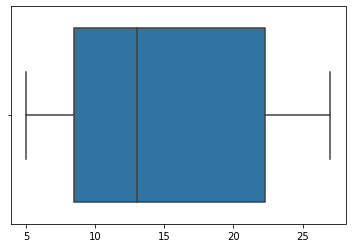

In [126]:
sns.boxplot(mean_res)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

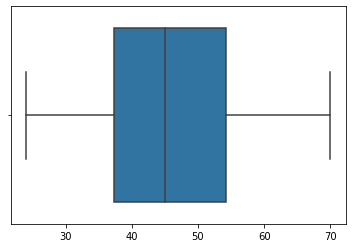

In [128]:
sns.boxplot(mean_res)

In [164]:
beta = [0.8]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res = [[] for j in range(10)]
    mean_param = []
    cov_param = []
    w_param = []
    for k in range(10):
        print(k)
        for n in range(1, 11, 1):
            print(n)
            means = []
            cov = []
            w = [1/n for _ in range(n)]
            for i in range(n):
                means.append([random.randint(-1000, 1000), random.randint(-1000, 1000), random.randint(-1000, 1000)])
                cov.append(make_spd_matrix(3))
            mean_param.append(means)
            cov_param.append(cov)
            w_param.append(w)
            generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
            sample = generator.sample(10000000)
            m = GaussianMixture(n_components=n).fit(sample)
            LL = round(m.lower_bound_,3)
            test = generator.sample(10000000)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(test)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res[n-1].append(size)
                    break
                else:
                    if size > 2000:
                        mean_res[n-1].append(size)
                        break
                    else:
                        continue
            if size == 10000000-1:
                mean_res[n-1].append(size)
    # mean_vector = np.sum(mean_res, axis=0)
    # mean_vector = [u/1 for u in mean_vector]
    # results[number] = mean_vector

0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [17]:
mean_res = [[14, 15, 13, 14, 20, 17, 25, 13, 15, 13], [37, 28, 31, 35, 44, 36, 35, 39, 45, 29], [43, 51, 56, 71, 74, 70, 56, 33, 61, 46], [77, 68, 78, 91, 68, 72, 75, 93, 72, 89], [98, 115, 98, 102, 136, 96, 101, 110, 111, 95], [141, 149, 127, 133, 117, 137, 109, 132, 126, 126], [153, 160, 150, 174, 140, 155, 158, 124, 152, 135], [164, 176, 195, 182, 200, 186, 189, 150, 180, 183], [219, 170, 181, 145, 207, 212, 213, 187, 214, 185], [219, 240, 242, 224, 250, 239, 229, 234, 212, 233]]
mean_res = [np.mean(l) for l in mean_res]

In [18]:
y = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
reg = LinearRegression().fit(np.transpose([mean_res]), y)
print(round(reg.coef_[0],3))
print(round(reg.intercept_,3))

0.042
0.547


Text(0, 0.5, 'Sample size')

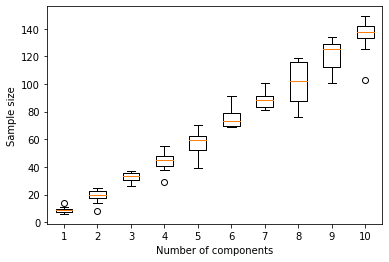

In [163]:
plt.boxplot(mean_res)
plt.xlabel('Number of components')
plt.ylabel('Sample size')

In [154]:
m = GMM(n_components=3).from_samples(geo[['Gross', 'Netpay']].values)

In [155]:
m.means

array([[1166.98118738,  159.1026037 ],
       [  36.2069098 ,   13.80837074],
       [ 168.10728445,   58.86814943]])

In [156]:
m.covariances

array([[[7.86946609e+05, 1.92546069e+04],
        [1.92546069e+04, 2.46692713e+04]],

       [[4.01122374e+02, 9.76328143e+01],
        [9.76328143e+01, 7.36824088e+01]],

       [[8.87962495e+03, 1.48485572e+03],
        [1.48485572e+03, 1.73659839e+03]]])

In [158]:

make_spd_matrix(2)

array([[ 4.99874425, -0.14000471],
       [-0.14000471,  1.05904253]])

In [147]:
mean_param

[[[-383]],
 [[566], [243]],
 [[-470], [-365], [238]],
 [[-907], [-63], [826], [-525]],
 [[-91], [432], [895], [425], [-704]],
 [[766], [-889], [-773], [784], [-477], [108]],
 [[-890], [-225], [-336], [-368], [798], [-573], [-833]],
 [[-755], [681], [-865], [599], [-398], [244], [-524], [970]],
 [[434], [-626], [569], [32], [175], [-251], [-399], [-139], [992]],
 [[660], [925], [-166], [244], [264], [289], [-502], [-192], [-570], [-689]],
 [[-388]],
 [[472], [-998]],
 [[442], [-371], [19]],
 [[382], [-937], [-106], [-300]],
 [[2], [923], [-772], [322], [659]],
 [[357], [-121], [724], [540], [308], [-765]],
 [[-549], [531], [534], [-106], [606], [-889], [222]],
 [[53], [-667], [-402], [811], [-554], [377], [-134], [465]],
 [[-865], [-982], [101], [-319], [252], [144], [-40], [-455], [191]],
 [[68], [820], [-626], [-199], [-512], [434], [-928], [-331], [-755], [152]],
 [[35]],
 [[-809], [-622]],
 [[-540], [-378], [-880]],
 [[798], [-701], [705], [-693]],
 [[-912], [-414], [-881], [-818], 

In [148]:
cov_param

[[[[388]]],
 [[[302]], [[376]]],
 [[[230]], [[107]], [[487]]],
 [[[500]], [[334]], [[282]], [[360]]],
 [[[207]], [[343]], [[271]], [[420]], [[296]]],
 [[[323]], [[428]], [[282]], [[104]], [[484]], [[479]]],
 [[[256]], [[107]], [[273]], [[401]], [[125]], [[466]], [[268]]],
 [[[443]], [[430]], [[165]], [[453]], [[309]], [[274]], [[113]], [[429]]],
 [[[453]],
  [[486]],
  [[487]],
  [[483]],
  [[428]],
  [[254]],
  [[293]],
  [[369]],
  [[336]]],
 [[[137]],
  [[201]],
  [[218]],
  [[121]],
  [[223]],
  [[214]],
  [[465]],
  [[294]],
  [[418]],
  [[468]]],
 [[[480]]],
 [[[284]], [[464]]],
 [[[451]], [[327]], [[187]]],
 [[[174]], [[289]], [[383]], [[362]]],
 [[[262]], [[409]], [[398]], [[249]], [[380]]],
 [[[241]], [[105]], [[259]], [[144]], [[351]], [[356]]],
 [[[410]], [[429]], [[235]], [[290]], [[218]], [[152]], [[363]]],
 [[[361]], [[166]], [[124]], [[134]], [[101]], [[131]], [[474]], [[110]]],
 [[[128]],
  [[117]],
  [[273]],
  [[109]],
  [[104]],
  [[208]],
  [[202]],
  [[251]],
  [[3

In [135]:
w_param

[[1.0],
 [0.5, 0.5],
 [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 [0.25, 0.25, 0.25, 0.25],
 [0.2, 0.2, 0.2, 0.2, 0.2],
 [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 [1.0],
 [0.5, 0.5],
 [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 [0.25, 0.25, 0.25, 0.25],
 [0.2, 0.2, 0.2, 0.2, 0.2],
 [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666

In [47]:
m = GMM(n_components=4, means=mean_param[3], covariances=cov_param[3], priors=w_param[3], random_state=random_state)

In [48]:
sample = m.sample(100000)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

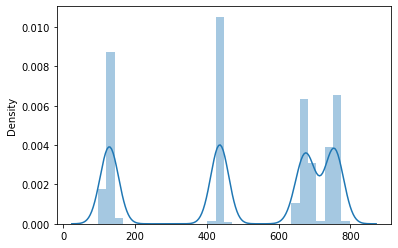

In [49]:
sns.distplot(sample)

In [50]:
m = GMM(n_components=5, means=mean_param[4], covariances=cov_param[4], priors=w_param[4], random_state=random_state)

In [51]:
sample = m.sample(100000)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

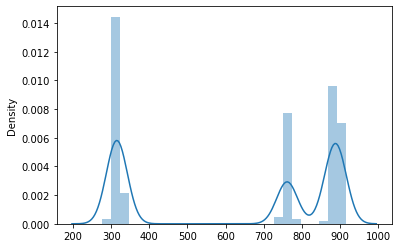

In [52]:
sns.distplot(sample)

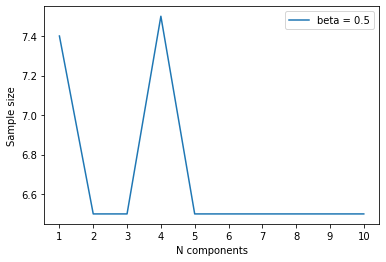

In [29]:
# plt.plot([i for i in range (1, 11, 1) ], results[0], label='beta = 0.99')
# plt.plot([i for i in range (1, 11, 1) ], results[1], label='beta = 0.95')
plt.plot([i for i in range (1, 11, 1) ], results[0], label='beta = 0.5')
plt.xlabel('N components')
plt.ylabel('Sample size')
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
plt.legend()

In [46]:
n_component(geo, ['Netpay', 'Gross'])

7

In [81]:
geo

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Depositional environment,Gross,Netpay,Porosity,Permeability,Depth,Oil density,Oil recovery factor
0,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,OIL,SHELF-,76.2,30.5,21.0,60.0,1510.7,825.072886,0.26
1,GRAVITY,CRETACEOUS,LIMESTONE,PASSIVE MARGIN,OIL,SHELF-,29.0,4.6,12.0,20.0,2652.4,801.699717,0.34
2,EXTENSION,PALEOGENE,THINLY-BEDDED SANDSTONE,RIFT,OIL,SLOPE APRON,91.5,82.3,35.0,3500.0,1720.1,933.993399,0.36
3,STRIKE-SLIP,ORDOVICIAN,DOLOMITE,INTRACRATONIC,OIL,OPEN SHELF,182.9,122.0,4.0,10.0,1158.5,815.561960,0.48
4,COMPRESSION,CARBONIFEROUS,LIMESTONE,SUB-SALT,OIL,SHELF-,91.5,32.0,10.0,20.0,1829.3,876.160991,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,LACUSTRINE FAN-DELTA,50.0,18.9,23.2,121.0,1439.3,946.488294,0.13
339,EXTENSION,PALEOGENE,SANDSTONE,RIFT,OIL,SUBLACUSTRINE FAN,89.9,24.1,21.0,60.0,2310.7,881.619938,0.19
340,EXTENSION,MESOZOIC,VOLCANICS,RIFT,OIL,NOT APPLICABLE,150.0,59.1,12.7,3.6,3000.9,870.769231,0.05
341,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,OIL,SHORELINE,79.9,10.1,24.0,30.0,570.1,887.147335,0.24


In [110]:
geo_sample = geo.loc[(geo['Tectonic regime'] == 'EXTENSION') & (geo['Lithology'] == 'SANDSTONE') & (geo['Period'] == 'JURASSIC')]
geo_sample.groupby('Lithology')['Lithology'].count()

Lithology
SANDSTONE    15
Name: Lithology, dtype: int64

In [111]:
geo_sample.shape

(15, 13)

In [113]:
n_component(geo_sample, ['Permeability', 'Oil density'])

4

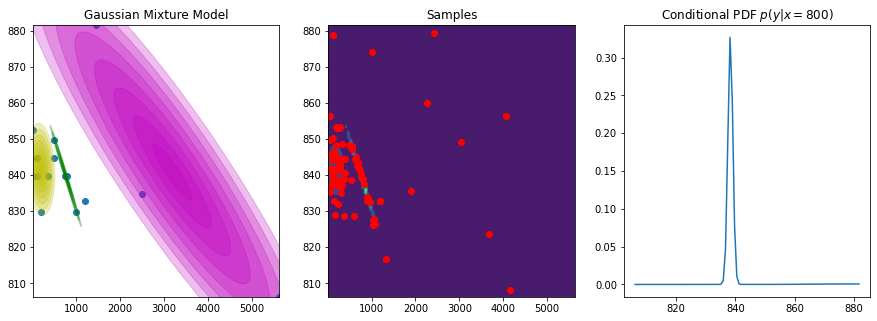

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = geo_sample.shape[0]
n_features = 2
# X = np.ndarray((n_samples, n_features))
# X[:n_samples // 3, :] = random_state.multivariate_normal(
#     [0.0, 1.0], [[0.5, -1.0], [-1.0, 5.0]], size=(n_samples // 3,))
# X[n_samples // 3:-n_samples // 3, :] = random_state.multivariate_normal(
#     [-2.0, -2.0], [[3.0, 1.0], [1.0, 1.0]], size=(n_samples // 3,))
# X[-n_samples // 3:, :] = random_state.multivariate_normal(
#     [3.0, 1.0], [[3.0, -1.0], [-1.0, 1.0]], size=(n_samples // 3,))
X = geo_sample[['Permeability', 'Oil density']].values

gmm = GMM(n_components=4, random_state=random_state)
gmm.from_samples(X)
cond = gmm.condition(np.array([0]), np.array([800]))
x_min = np.min(geo_sample['Permeability'].values)
x_max = np.max(geo_sample['Permeability'].values)
y_min = np.min(geo_sample['Oil density'].values)
y_max = np.max(geo_sample['Oil density'].values)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Gaussian Mixture Model")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plot_error_ellipses(plt.gca(), gmm, colors=["c", "m", "y", "g"])
plt.scatter(X[:, 0], X[:, 1])

plt.subplot(1, 3, 2)
plt.title("Samples")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
X_test = np.vstack((x.ravel(), y.ravel())).T
p = gmm.to_probability_density(X_test)
p = p.reshape(*x.shape)
plt.contourf(x, y, p)
X_sampled = gmm.sample(100)
plt.scatter(X_sampled[:, 0], X_sampled[:, 1], c="r")

plt.subplot(1, 3, 3)
plt.title("Conditional PDF $p(y | x = 800)$")
X_test = np.linspace(y_min, y_max, 100)
plt.plot(X_test, cond.to_probability_density(X_test[:, np.newaxis]))

plt.show()

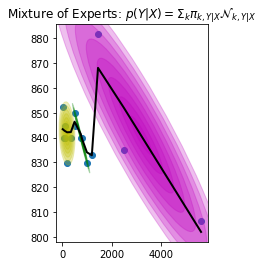

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = geo_sample.shape[0]
# X = np.ndarray((n_samples, 2))
# X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
# X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)
X = geo_sample[['Permeability', 'Oil density']].values


X_test = np.array(sorted(geo_sample['Permeability'].values))

gmm = GMM(n_components=4, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["c", "m", "y", "g"])
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

In [15]:
def quantile2d(x,y,Nbins,nth):
    def myperc(x,n=nth):
        return(percentile(x,n))
    t=binned_statistic(x,y,statistic=myperc,bins=Nbins)
    v=[]
    for i in range(len(t[0])): v.append((t[1][i+1]+t[1][i])/2.)
    v=np.array(v)
    return(t,v)

In [25]:
x = geo['Permeability'].values
y = geo['Oil recovery factor'].values
Nbins=400
nth=95.
t,v=quantile2d(x,y,Nbins,nth)
ii=[]
for i in range(Nbins):
    ii=ii+np.argwhere(((t.binnumber==i) & (y<t.statistic[i]))).flatten().tolist()
ii=np.array(ii,dtype=int)

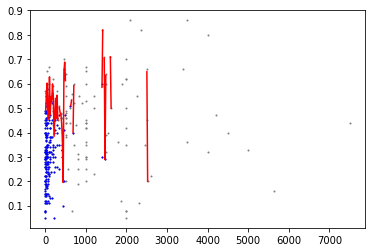

In [26]:
plt.plot(x,y,'o',color='gray',ms=1,zorder=1)
plt.plot(v,t.statistic,'r-',zorder=3)
plt.plot(x[ii],y[ii],'o',color='blue',ms=1,zorder=2)